# 使用Tensorflow (低级API)构建CNN对MINIST数据进行分类

构建CNN来对MNIST手写数字进行识别来探索Tensorflow。<br>

# 导入数据

In [1]:
import tensorflow as tf
train, test = tf.keras.datasets.mnist.load_data()
mnist_x, mnist_y = train

mnist_y = tf.keras.utils.to_categorical(mnist_y, 10)

In [2]:
type(mnist_x[1])

numpy.ndarray

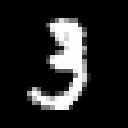

In [3]:
from PIL import Image
Image.fromarray(mnist_x[10]).resize((128, 128))

In [4]:
test[1]

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

# 构建Softmax 回归模型
在这一节中我们将建立一个拥有一个线性层的softmax回归模型。

使用TensorFlow之前，首先导入它：

In [5]:
import tensorflow as tf
sess = tf.InteractiveSession()

# 构建一个多层卷积网络

在MNIST上只有91%正确率，实在太糟糕。在这个小节里，我们用一个稍微复杂的模型：卷积神经网络来改善效果。这会达到大概99.2%的准确率。虽然不是最高，但是还是比较让人满意。

# 权重初始化

为了创建这个模型，我们需要创建大量的权重和偏置项。

这个模型中的权重在初始化时应该加入少量的噪声来打破对称性以及避免0梯度。

由于我们使用的是ReLU神经元，因此比较好的做法是用一个较小的正数来初始化偏置项，以避免神经元节点输出恒为0的问题（dead neurons）。

为了不在建立模型的时候反复做初始化操作，我们定义两个函数用于初始化。


In [6]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

# 卷积和池化

TensorFlow在卷积和池化上有很强的灵活性。我们怎么处理边界？步长应该设多大？

在这个实例里，我们会一直使用vanilla版本。我们的卷积使用1步长（stride size），0边距（padding size）的模板，保证输出和输入是同一个大小。

我们的池化用简单传统的2x2大小的模板做max pooling。

为了代码更简洁，我们把这部分抽象成一个函数。

In [7]:
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# 占位符
我们通过为输入图像和目标输出类别创建节点，来开始构建计算图。

In [8]:
x = tf.placeholder("float", shape=[None, 28, 28, 1])
y_ = tf.placeholder("float", shape=[None, 10])

# 第一层卷积
现在我们可以开始实现第一层了。

它由一个卷积接一个max pooling完成。

卷积在每个5x5的patch中算出32个特征。

卷积的权重张量形状是[5, 5, 1, 32]，前两个维度是patch的大小，接着是输入的通道数目，最后是输出的通道数目。

而对于每一个输出通道都有一个对应的偏置量。

In [9]:
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

Instructions for updating:
Colocations handled automatically by placer.


为了用这一层，我们把x变成一个4d向量，其第2、第3维对应图片的宽、高，最后一维代表图片的颜色通道数(因为是灰度图所以这里的通道数为1，如果是rgb彩色图，则为3)。

In [10]:
#x_image = tf.reshape(x, [-1, 28, 28, 1])

我们把x_image和权值向量进行卷积，加上偏置项，然后应用ReLU激活函数，最后进行max pooling。

In [11]:
h_conv1 = tf.nn.relu(conv2d(x, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

# 第二层卷积
为了构建一个更深的网络，我们会把几个类似的层堆叠起来。第二层中，每个5x5的patch会得到64个特征。

In [12]:
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

# 全连接层
现在，图片尺寸减小到7x7，我们加入一个有1024个神经元的全连接层，用于处理整个图片。我们把池化层输出的张量reshape成一些向量，乘上权重矩阵，加上偏置，然后对其使用ReLU。

In [13]:
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

# Dropout
为了减少过拟合，我们在输出层之前加入dropout。
我们用一个placeholder来代表一个神经元的输出在dropout中保持不变的概率。
这样我们可以在训练过程中启用dropout，在测试过程中关闭dropout。 
TensorFlow的tf.nn.dropout操作除了可以屏蔽神经元的输出外，还会自动处理神经元输出值的scale。所以用dropout的时候可以不用考虑scale。

In [14]:
keep_prob = tf.placeholder("float")
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


# 输出层
最后，我们添加一个softmax层，就像前面的单层softmax regression一样。

In [15]:
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)


# 训练和评估模型
这个模型的效果如何呢？

为了进行训练和评估，我们使用与之前简单的单层SoftMax神经网络模型几乎相同的一套代码，

只是我们会用更加复杂的ADAM优化器来做梯度最速下降，

在feed_dict中加入额外的参数keep_prob来控制dropout比例。

然后每100次迭代输出一次日志。

In [16]:
cross_entropy_map = tf.losses.softmax_cross_entropy(onehot_labels=y_, logits=y)
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy_map)
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

sess.run(tf.global_variables_initializer())

Instructions for updating:
Use tf.cast instead.


In [17]:
assert mnist_x.shape[0] == mnist_y.shape[0]

In [18]:
features_placeholder = tf.placeholder(mnist_x.dtype, mnist_x.shape)
labels_placeholder = tf.placeholder(mnist_y.dtype, mnist_y.shape)
dataset = tf.data.Dataset.from_tensor_slices((features_placeholder, labels_placeholder))

In [19]:
dataset = dataset.shuffle(buffer_size=1000)
dataset = dataset.repeat(20)
dataset = dataset.batch(128)

In [20]:
iterator = dataset.make_initializable_iterator()
sess.run(iterator.initializer, feed_dict={features_placeholder: mnist_x, labels_placeholder: mnist_y})

In [21]:
next_element = iterator.get_next()

In [22]:
import numpy as np
step = 1
try:
    while True:
        batch = sess.run(next_element, feed_dict={features_placeholder: mnist_x, labels_placeholder: mnist_y})
        features = batch[0][:, :, :, np.newaxis]
        label = batch[1]
        
        train_accuracy = accuracy.eval(feed_dict={x: features , y_: label, keep_prob: 1.0})
        #print(tf.argmax(y, 1).eval(feed_dict={x: features, y_: label, keep_prob: 1.0}))
        #print(tf.argmax(y_, 1).eval(feed_dict={x: features, y_: label, keep_prob: 1.0}))
        train_step.run(feed_dict={x: features, y_: label, keep_prob: 0.5})
        
        step = step + 1
        if step % 200 == 0:
            print("\nstep %d, training accuracy %f " % (step, train_accuracy))
        elif step % 20 == 0:
            print('.', end='')
        
except tf.errors.OutOfRangeError:
    print("End of dataset")
print(step)

.........
step 200, training accuracy 0.179688 
.........
step 400, training accuracy 0.218750 
.........
step 600, training accuracy 0.265625 
.........
step 800, training accuracy 0.226562 
.........
step 1000, training accuracy 0.226562 
.........
step 1200, training accuracy 0.218750 
.........
step 1400, training accuracy 0.210938 
.........
step 1600, training accuracy 0.242188 
.........
step 1800, training accuracy 0.265625 
.........
step 2000, training accuracy 0.359375 
.........
step 2200, training accuracy 0.304688 
.........
step 2400, training accuracy 0.351562 
.........
step 2600, training accuracy 0.234375 
.........
step 2800, training accuracy 0.117188 
.........
step 3000, training accuracy 0.312500 
.........
step 3200, training accuracy 0.265625 
.........
step 3400, training accuracy 0.289062 
.........
step 3600, training accuracy 0.250000 
.........
step 3800, training accuracy 0.281250 
.........
step 4000, training accuracy 0.273438 
.........
step 4200, tra

In [23]:
features , label = test
features = features[:, :, :, np.newaxis]
label = tf.keras.utils.to_categorical(label, 10)

In [24]:
test[0].shape

(10000, 28, 28)

In [25]:
test[1].shape

(10000,)

In [26]:
test_accuracy = accuracy.eval(feed_dict={x: features , y_: label, keep_prob: 1.0})

目前为止，我们已经学会了用TensorFlow快捷地搭建、训练和评估一个复杂一点儿的深度学习模型。

In [27]:
test_accuracy

0.563

In [28]:
tf.argmax(y, 1).eval(feed_dict={x: features , y_: label, keep_prob: 1.0})
#train_step.run(feed_dict={x: features, y_: label, keep_prob: 0.5})

array([7, 3, 1, ..., 4, 8, 4])

In [29]:
tf.argmax(y_, 1).eval(feed_dict={x: features , y_: label, keep_prob: 1.0})

array([7, 2, 1, ..., 4, 5, 6])